## The Racetrack Environment
We have implemented a custom environment called "Racetrack" for you to use during this piece of work. 
### Environment Description
Consider driving a race car around a turn on a racetrack. In order to complete the race as quickly as possible, you would want to drive as fast as you can but, to avoid running off the track, you must slow down while turning.

In our simplified racetrack environment, the agent is at one of a discrete set of grid positions. The agent also has a discrete speed in two directions, $x$ and $y$. So the state is represented as follows:
$$(\text{position}_y, \text{position}_x, \text{velocity}_y, \text{velocity}_x)$$

The agent collects a reward of -1 at each time step, an additional -10 for leaving the track (i.e., ending up on a black grid square in the figure below), and an additional +10 for reaching the finish line (any of the red grid squares). The agent starts each episode on a randomly selected grid-square on the starting line (green grid squares) with a speed of zero in both directions. At each time step, the agent can change its speed in both directions. Each speed can be changed by +1, -1 or 0, giving a total of nine actions. For example, the agent may increase its speed in the $x$ direction by -1 and its speed in the $y$ direction by +1. The agent's speed cannot be greater than +10 or less than -10 in either direction.

<img src="images/track_big.png" style="width: 600px;"/>


The agent's next state is determined by its current grid square, its current speed in two directions, and the changes it  makes to its speed in the two directions. This environment is stochastic. When the agent tries to change its speed, no change occurs (in either direction) with probability 0.2. In other words, 20% of the time, the agent's action is ignored and the car's speed remains the same in both directions.

If the agent leaves the track, it is returned to a random start grid-square and has its speed set to zero in both directions; the episode continues. An episode ends only when the agent transitions to a goal grid-square.



### Environment Implementation
We have implemented the above environment in the `racetrack_env.py` file, for you to use in this work. Please use this implementation instead of writing your own, and please do not modify the environment.

We provide a `RacetrackEnv` class for your agents to interact with. The class has the following methods:
- **`reset()`** - this method initialises the environment, chooses a random starting state, and returns it. This method should be called before the start of every episode.
- **`step(action)`** - this method takes an integer action (more on this later), and executes one time-step in the environment. It returns a tuple containing the next state, the reward collected, and whether the next state is a terminal state.
- **`render(sleep_time)`** - this method renders a matplotlib graph representing the environment. It takes an optional float parameter giving the number of seconds to display each time-step. This method is useful for testing and debugging, but should not be used during training since it is *very* slow. **Do not use this method in your final submission**.
- **`get_actions()`** - a simple method that returns the available actions in the current state. Always returns a list containing integers in the range [0-8] (more on this later).

In our code, states are represented as Python tuples - specifically a tuple of four integers. For example, if the agent is in a grid square with coordinates ($Y = 2$, $X = 3$), and is moving zero cells vertically and one cell horizontally per time-step, the state is represented as `(2, 3, 0, 1)`. Tuples of this kind will be returned by the `reset()` and `step(action)` methods. It is worth noting that tuples can be used to index certain Python data-structures, such as dictionaries.

There are nine actions available to the agent in each state, as described above. However, to simplify your code, we have represented each of the nine actions as an integer in the range [0-8]. The table below shows the index of each action, along with the corresponding changes it will cause to the agent's speed in each direction.

<img src="images/action_grid.png" style="width: 250px;"/>

For example, taking action 8 will increase the agent's speed in the $x$ direction, but decrease its speed in the $y$ direction.

# Racetrack Code Example
Below, we go through a quick example of using the RaceTrackEnv class.
First, we import the class, then create a RaceTrackEnv object called env. We then initialise the environment using the reset() method, and take a look at the initial state variable and the result of plot().

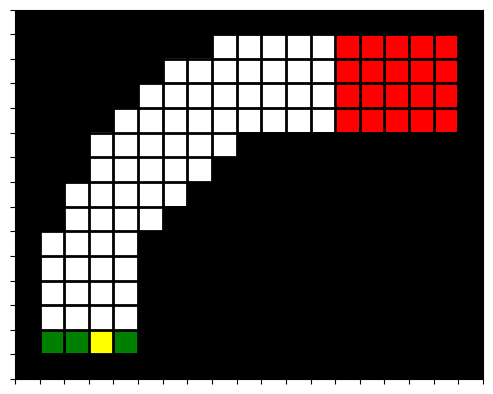

Initial State: (1, 3, 0, 0)


In [1]:
%matplotlib inline

# Set random seed to make example reproducable.
import numpy as np
import random
seed = 5
random.seed(seed)
np.random.seed(seed)

from racetrack_env import RacetrackEnv

# Instantiate environment object.
env = RacetrackEnv()

# Initialise/reset environment.
state = env.reset()
env.render()
print("Initial State: {}".format(state))

As you can see, reset() has returned a valid initial state as a four-tuple. The function plot() uses the same colour-scheme as described above, but also includes a yellow grid-square to indicate the current position of the agent.
Let's make the agent go upward by using step(1), then inspect the result (recall that action 1 increments the agent's vertical speed while leaving the agent's horizontal speed unchanged).

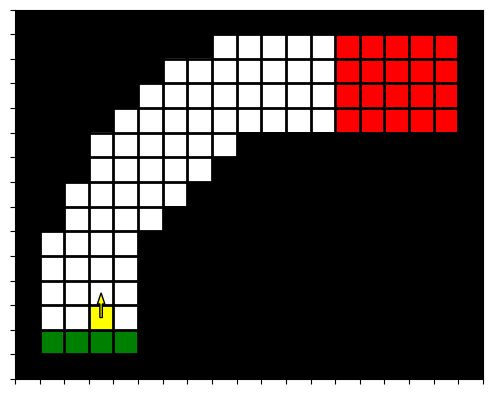

Next State: (2, 3, 1, 0), Reward: -1, Terminal: False


In [3]:
# Let us increase the agent's vertical speed (action 1).
next_state, reward, terminal = env.step(1)
env.render()
print("Next State: {}, Reward: {}, Terminal: {}".format(next_state, reward, terminal))

You can see that the agent has moved one square upwards, and now has a positive vertical speed (indicated by the yellow arrow). Let's set up a loop to see what happens if we take the action a few more times, causing it to repeatedly leave the track.

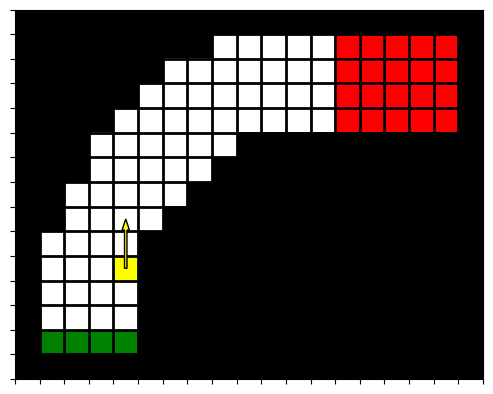

In [4]:
num_steps = 50
for t in range(num_steps) :
    next_state, reward, terminal = env.step(1)
    env.render()

### Below, we have plotted learning curves showing the performance of On-Policy Monte Carlo Control, Sarsa, and Q-Learning in the Racetrack environment. We have included an unaltered version of the learning curve, as well as a cropped version to make it easier to compare agents' performance towards the end of training.

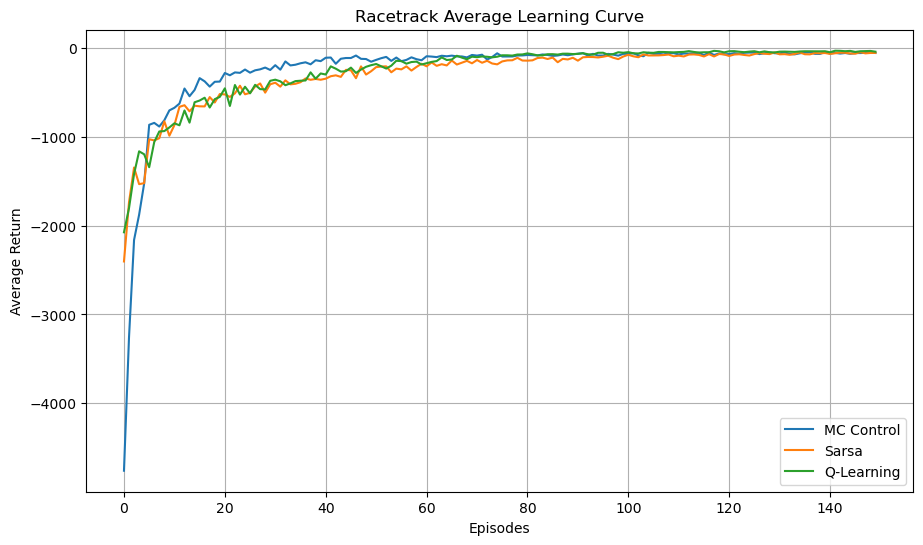

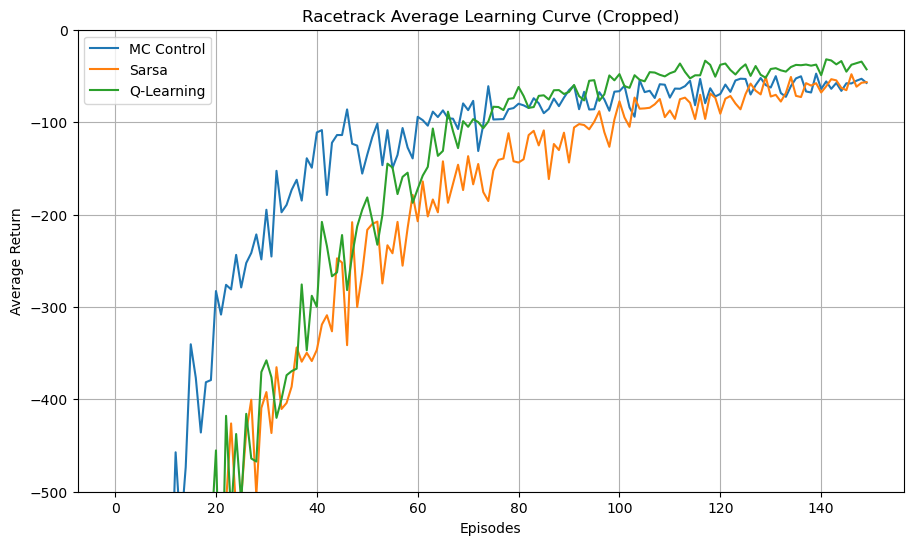

In [5]:
from racetrack_env import plot_combined_results

# Plotting Combined Learning Curve.
%matplotlib inline
plot_combined_results()

## Modified Temporal-Difference Learning Agent 
Implementation
<img src="images/q_learning_algo.png" style="width: 650px;"/>

In this notebook, you must implement a Temporal-Difference learning agent that learns to reach a goal state in the racetrack more efficiently than the Q-Learning agent shown above. You may base your implementation on Q-Learning (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131), the pseudocode for which is reproduced below, but you may also base your implementation on Sarsa if you wish.


Please use the following parameter settings:
Number of training episodes  =150 .
Number of agents averaged should be at least 5.

You may adjust all other parameters as you see fit.
Your implementation of a tabular modified Temporal-Difference learning agent should produce a list named modified_agent_rewards. This list should contain one list for each agent that you train. Each sub-list should contain the undiscounted sum of rewards earned during each episode by the corresponding agent.
For example, if you train  20  agents, your modified_agent_rewards list will contain  20  sub-lists, each containing  150  integers. This list will be used to plot an average learning curve, which will be used to mark your work.

In [6]:
import numpy as np
import random
from collections import deque

class SarsaLambdaAgent:
    def __init__(self, env, alp=0.2, gamma=0.9, epsilon=0.05, lambd=0.7, buffer_size=10000):
        self.env = env
        self.alp = alp
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambd = lambd
        self.q_values = {}
        self.eligibility_trace = {}
        self.replay_buffer = deque(maxlen=buffer_size)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return np.random.choice(self.env.get_actions())
        else:
            return max(self.env.get_actions(), key=lambda a: self.get_q_value(state, a))

    def get_q_value(self, state, action):
        return self.q_values.get((state, action), 0)

    def update_q_values(self, delta):
        for (state, action), eligibility in self.eligibility_trace.items():
            self.q_values[(state, action)] += self.alp * delta * eligibility
            self.eligibility_trace[(state, action)] *= self.gamma * self.lambd

    def train(self, episodes):
        all_rewards = []
        for _ in range(episodes):
            state = self.env.reset()
            total_reward = 0
            self.eligibility_trace.clear()
            action = self.select_action(state)
            for _ in range(1000):
                next_state, reward, terminal = self.env.step(action)
                next_action = self.select_action(next_state)
                if (state, action) not in self.q_values:
                    self.q_values[(state, action)] = 0
                delta = reward + self.gamma * self.get_q_value(next_state, next_action) - self.get_q_value(state, action)
                self.eligibility_trace[(state, action)] = 1
                self.update_q_values(delta)
                self.replay_buffer.append((state, action, reward, next_state, terminal))
                total_reward += reward
                state = next_state
                action = next_action
                if terminal:
                    break

            all_rewards.append(total_reward)
        
        return all_rewards

episodes = 150
agents = 10
env = RacetrackEnv()
modified_agent_rewards = []

for _ in range(agents):
    agent =SarsaLambdaAgent(env)
    agent_rewards = agent.train(episodes)
    modified_agent_rewards.append(agent_rewards)

for agent_idx, rewards in enumerate(modified_agent_rewards):
    print(f"Agent {agent_idx + 1} rewards: {rewards}")


Agent 1 rewards: [-3450, -2820, -2710, -2480, -2520, -2470, -2448, -796, -272, -14, -24, -53, -69, -107, 1, -34, -74, -55, -75, 2, 1, -33, -12, 2, -51, -17, 2, -17, -220, 1, -27, -41, -20, -94, 2, -76, 1, -39, -24, -91, 2, 1, -32, -16, -86, -35, -17, 2, -53, -101, 1, -13, -16, -32, 2, 2, 2, -20, 1, 2, 2, -86, 1, 2, -34, -1, -34, -83, -16, -30, -47, -16, -34, 1, 1, -14, -69, 2, -15, -6, -16, -58, -17, 2, -35, 0, -80, -34, 2, 2, 1, 2, -10, 2, -48, 2, 2, 2, -46, 2, -15, -62, 2, -1, -3, -56, -12, 0, -64, 2, 0, 3, 2, -104, -12, -15, -10, 1, 0, 2, -118, 2, -5, -18, -37, -17, 1, -2, -28, -17, 2, -14, -30, -18, -41, -16, -78, -15, -40, 0, -52, -69, -14, 1, -65, -25, 2, -72, -32, -49]
Agent 2 rewards: [-3450, -2850, -2690, -2540, -2490, -2430, -754, -756, -2380, -22, -113, -308, -15, 4, -14, -115, -59, 3, -113, -337, -197, -161, -118, -34, -37, -125, -133, -51, -212, -218, -111, -47, -203, 2, -130, -19, -16, 2, -72, -153, 1, 0, -19, -84, 0, 0, -119, -30, 3, 0, -36, -49, -40, -116, -70, -4, -36,

Below, we have used your results to plot the performance of your modified agent and a Q-Learning agent on the same set of axes.
A cropped version of this learning curve has also been plotted, to make it easier to compare the performance of your agents towards the end of training

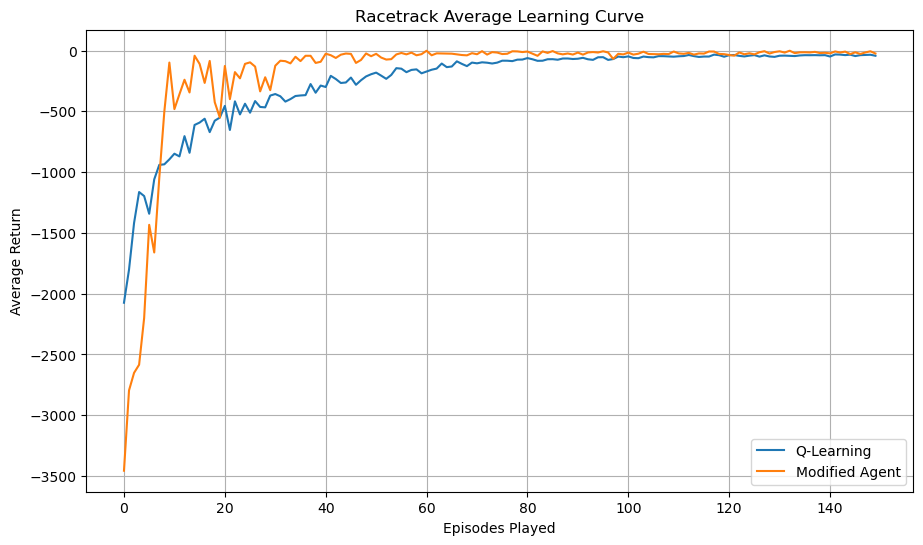

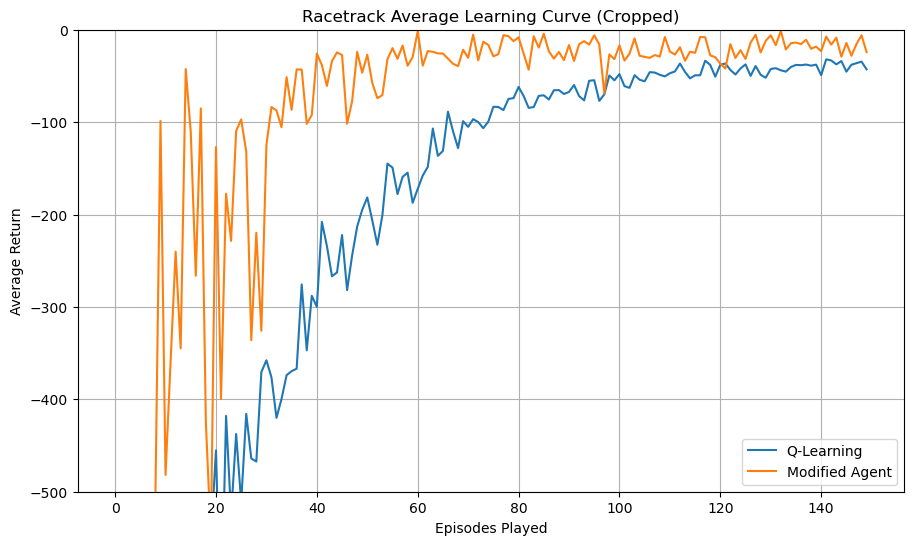

In [7]:
from racetrack_env import plot_modified_agent_results
from racetrack_env import simple_issue_checking

# Checking Modified Agent Results for Obvious Issues.
simple_issue_checking(modified_agent_rewards, modified_agent = True)

# Plotting Modified Agent Learning Curve.
%matplotlib inline
plot_modified_agent_results(modified_agent_rewards)